##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural machine translation with attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/nmt_with_attention">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/nmt_with_attention.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to train a sequence-to-sequence (seq2seq) model for Spanish-to-English translation roughly based on [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015). 

<table>
<tr>
  <td>
   <img width=400 src="https://www.tensorflow.org/images/tutorials/transformer/RNN%2Battention-words-spa.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>This tutorial: An encoder/decoder connected by attention.</th>
<tr>
</table>

While this architecture is somewhat outdated, it is still a very useful project to work through to get a deeper understanding of sequence-to-sequence models and attention mechanisms (before going on to [Transformers](transformer.ipynb)).

## Setup

In [2]:
import numpy as np

import typing
from typing import Any, Tuple

import einops
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import tensorflow as tf
import tensorflow_text as tf_text

from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

2024-01-23 17:55:08.760301: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-23 17:55:08.760349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-23 17:55:08.779875: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-23 17:55:08.860652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-23 17:55:09.943636: W tensorflow/compiler/tf2

This tutorial uses a lot of low level API's where it's easy to get shapes wrong. This class is used to check shapes throughout the tutorial.


In [3]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

## The data

The tutorial uses a language dataset provided by [Anki](http://www.manythings.org/anki/). This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

They have a variety of languages available, but this example uses the English-Spanish dataset.

### Download and prepare the dataset

For convenience, a copy of this dataset is hosted on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps you need to take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [4]:
from datasets import load_dataset

dataset = load_dataset("Nicolas-BZRD/Parallel_Global_Voices_English_French", split='train').to_pandas()
dataset.head()

/home/marwan/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,en,fr
0,Jamaica: “I am HIV”,Jamaïque : J’ai le VIH
1,"It's widely acknowledged, in the Caribbean and...","Il est largement reconnu, dans les Caraïbes et..."
2,"For this woman, however, photographed in the s...","Pour cette femme, cependant, photographiée dan..."
3,As Bacon writes on her blog:,Comme Bacon écrit sur son blog:
4,"“When I asked to take her picture, I suggested...",“Quand je lui ai demandé de la prendre en phot...


In [5]:
def load_data(dataset):
  context = np.array([context for context in dataset['fr']])
  target = np.array([target for target in dataset['en']])

  return target, context

In [6]:
target_raw, context_raw = load_data(dataset)
print(context_raw[-1])

Seulement, aujourd'hui, elle ne porte pas de bracelets.


In [7]:
print(target_raw[-1])

But now she's not wearing bangles.


In [8]:
len(context_raw)

342060

### Create a tf.data dataset

From these arrays of strings you can create a `tf.data.Dataset` of strings that shuffles and batches them efficiently:

In [9]:
BUFFER_SIZE = len(context_raw)
BATCH_SIZE = 64

# Set a random seed for reproducibility
np.random.seed(42)

# Shuffle the indices
indices = np.arange(len(target_raw))
np.random.shuffle(indices)

# Determine the sizes of the train, validation, and test sets
train_size = int(0.8 * len(target_raw))
val_size = int(0.1 * len(target_raw))
test_size = len(target_raw) - train_size - val_size

# Use the shuffled indices to create subsets
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Create datasets
train_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[train_indices], target_raw[train_indices]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

val_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[val_indices], target_raw[val_indices]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))

test_raw = (
    tf.data.Dataset
    .from_tensor_slices((context_raw[test_indices], target_raw[test_indices]))
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE))


2024-01-23 17:55:20.754355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:55:20.952212: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:55:20.952273: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:55:20.954039: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-23 17:55:20.954089: I external/local_xla/xla/stream_executor

In [10]:
nb_context_test = test_raw.reduce(0, lambda x, batch: x + tf.shape(batch[0])[0]).numpy()
nb_context_val = val_raw.reduce(0, lambda x, batch: x + tf.shape(batch[0])[0]).numpy()
nb_context_train = train_raw.reduce(0, lambda x, batch: x + tf.shape(batch[0])[0]).numpy()

print("Total number of context strings in the test dataset:", nb_context_test)
print("Total number of context strings in the validation dataset:", nb_context_val)
print("Total number of context strings in the training dataset:", nb_context_train)

print("Total number of context strings in the dataset:", nb_context_test + nb_context_val + nb_context_train)

Total number of context strings in the test dataset: 34206
Total number of context strings in the validation dataset: 34206
Total number of context strings in the training dataset: 273648
Total number of context strings in the dataset: 342060


In [11]:
for example_context_strings, example_target_strings in train_raw.take(1):
  print(example_context_strings[:5])
  print()
  print(example_target_strings[:5])
  break

tf.Tensor(
[b"\xc3\x87a semble toujours impossible jusqu'\xc3\xa0 ce que \xc3\xa7a devienne une r\xc3\xa9alit\xc3\xa9, si vous croyez en vous-m\xc3\xaame et persistez, vous verrez les r\xc3\xa9sultats."
 b"Les pays \xc3\xa9trangers qui ont soutenu les Khmers Rouges, ou \xc3\xa9t\xc3\xa9 les catalyseurs principaux de l'\xc3\xa9mergence de ce r\xc3\xa9gime cruel, ne seront pas train\xc3\xa9s en justice."
 b"De toute fa\xc3\xa7on, nous esp\xc3\xa9rons qu'il existe un juste milieu qui n'implique pas de schtroumpfs, des nains ou l'am\xc3\xa9ricanisation compl\xc3\xa8te des traditions dans le monde."
 b'Pointant du doigt la nette fracture entre la classe dirigeante et le reste du pays, le blogeur Alick Nyasulu \xc3\xa9crit dans un billet publi\xc3\xa9 dans le journal The Nation que le gouvernement ne remplit pas le contrat social qui le lie au peuple malawite :'
 b'Bataille de Kiev.'], shape=(5,), dtype=string)

tf.Tensor(
[b'It always does seem it is impossible until it is done but if you b

### Text preprocessing

One of the goals of this tutorial is to build a model that can be exported as a `tf.saved_model`. To make that exported model useful it should take `tf.string` inputs, and return `tf.string` outputs: All the text processing happens inside the model. Mainly using a `layers.TextVectorization` layer.

#### Standardization

The model is dealing with multilingual text with a limited vocabulary. So it will be important to standardize the input text.

The first step is Unicode normalization to split accented characters and replace compatibility characters with their ASCII equivalents.

The `tensorflow_text` package contains a unicode normalize operation:

In [12]:
example_text = tf.constant('Aujourd’hui, il fait beau.')

print(example_text.numpy())
print(tf_text.normalize_utf8(example_text, 'NFKD').numpy())

b'Aujourd\xe2\x80\x99hui, il fait beau.'
b'Aujourd\xe2\x80\x99hui, il fait beau.'


Unicode normalization will be the first step in the text standardization function:

In [13]:
def tf_lower_and_split_punct(text):
  # Split accented characters.
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Keep space, a to z, and select punctuation.
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  # Add spaces around punctuation.
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [14]:
print(example_text.numpy().decode())
print(tf_lower_and_split_punct(example_text).numpy().decode())

Aujourd’hui, il fait beau.
[START] aujourdhui ,  il fait beau . [END]


#### Text Vectorization

This standardization function will be wrapped up in a `tf.keras.layers.TextVectorization` layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [15]:
max_vocab_size = 5000

context_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

The `TextVectorization` layer and many other [Keras preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) have an `adapt` method. This method reads one epoch of the training data, and works a lot like `Model.fit`. This `adapt` method initializes the layer based on the data. Here it determines the vocabulary:

In [16]:
context_text_processor.adapt(train_raw.map(lambda context, target: context))
context_text_processor.adapt(test_raw.map(lambda context, target: context))

# Here are the first 10 words from the vocabulary:
context_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'de', ',', '[START]', '[END]', '.', 'la', 'a', 'le']

That's the Spanish `TextVectorization` layer, now build and `.adapt()` the English one:

In [17]:
target_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_lower_and_split_punct,
    max_tokens=max_vocab_size,
    ragged=True)

target_text_processor.adapt(train_raw.map(lambda context, target: target))
target_text_processor.adapt(test_raw.map(lambda context, target: target))

target_text_processor.get_vocabulary()[:10]

['', '[UNK]', 'the', '[START]', '[END]', ',', '.', 'of', 'to', 'and']

Now these layers can convert a batch of strings into a batch of token IDs:

In [18]:
example_tokens = context_text_processor(example_context_strings)
example_tokens[:3, :]

2024-01-23 17:55:52.567114: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


<tf.RaggedTensor [[4, 175, 325, 137, 1324, 309, 26, 14, 175, 4506, 21, 573, 3, 50, 49, 1, 13,
  1, 11, 1, 3, 49, 1, 10, 510, 6, 5]                                        ,
 [4, 10, 45, 624, 18, 27, 1840, 10, 1, 1979, 3, 36, 33, 10, 1, 1013, 2, 1,
  2, 26, 339, 1, 3, 29, 508, 23, 1, 13, 301, 6, 5]                        ,
 [4, 2, 190, 235, 3, 32, 2115, 58, 694, 16, 327, 1131, 18, 1, 23, 2, 1, 3,
  12, 1, 36, 1, 2126, 12, 2022, 20, 9, 71, 6, 5]                          ]>

The `get_vocabulary` method can be used to convert token IDs back to text:

In [19]:
target_vocab = np.array(target_text_processor.get_vocabulary())
context_vocab = np.array(context_text_processor.get_vocabulary())

In [20]:
tokens = context_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] ca semble toujours impossible jusqua ce que ca devienne une realite , si vous [UNK] en [UNK] et [UNK] , vous [UNK] les resultats . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

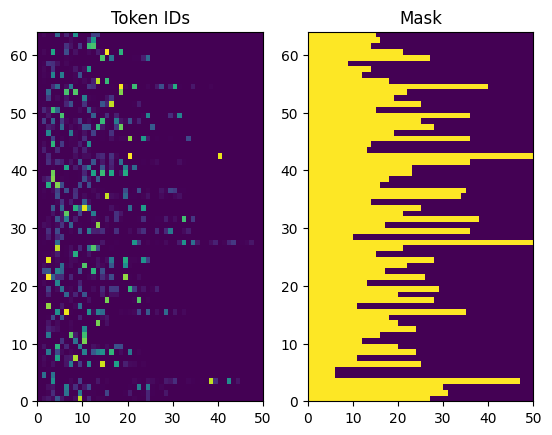

In [21]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens.to_tensor())
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens.to_tensor() != 0)
plt.title('Mask')

### Process the dataset



The `process_text` function below converts the `Datasets` of strings, into  0-padded tensors of token IDs. It also converts from a `(context, target)` pair to an `((context, target_in), target_out)` pair for training with `keras.Model.fit`. Keras expects `(inputs, labels)` pairs, the inputs are the `(context, target_in)` and the labels are `target_out`. The difference between `target_in` and `target_out` is that they are shifted by one step relative to eachother, so that at each location the label is the next token.

In [22]:
def process_text(context, target):
  context = context_text_processor(context).to_tensor()
  target = target_text_processor(target)
  targ_in = target[:,:-1].to_tensor()
  targ_out = target[:,1:].to_tensor()
  return (context, targ_in), targ_out


train_ds = train_raw.map(process_text, tf.data.AUTOTUNE)
val_ds = val_raw.map(process_text, tf.data.AUTOTUNE)
test_ds = test_raw.map(process_text, tf.data.AUTOTUNE)

Here is the first sequence of each, from the first batch:

In [23]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
  print(ex_context_tok[0, :10].numpy()) 
  print()
  print(ex_tar_in[0, :10].numpy()) 
  print(ex_tar_out[0, :10].numpy()) 

[  4 547 285   1   2   7 281  57 143   2]

[  3  12  19 256   1  15  11 893 155   8]
[ 12  19 256   1  15  11 893 155   8 946]


We can decode the token IDs back to text by using the vocabulary lookup of each, the context and target 

In [24]:
for (ex_context_tok, ex_tar_in), ex_tar_out in test_ds.take(1):
    tokens = context_vocab[ex_context_tok[0].numpy()]
    print('> French : ' + ' '.join(tokens))
    tokens = target_vocab[ex_tar_in[0].numpy()]
    print('> English Input : ' + ' '.join(tokens))
    break

> French : [START] tout cela au nom de la legitime defense . [END]                                            
> English Input : [START] all in the name of selfdefense .                                             


## The encoder/decoder

The following diagrams shows an overview of the model. In both the encoder is on the left, the decoder is on the right. At each time-step the decoder's output is combined with the encoder's output, to predict the next word. 

The original [left] contains a few extra connections that are intentionally omitted from this tutorial's model [right], as they are generally unnecessary, and difficult to implement. Those missing connections are:

1. Feeding the state from the encoder's RNN to the decoder's RNN
2. Feeding the attention output back to the RNN's input.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg"/>
  </td>
  <td>
   <img width=380 src="https://www.tensorflow.org/images/tutorials/transformer/RNN+attention.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The original from <a href=https://arxiv.org/abs/1508.04025v5>Effective Approaches to Attention-based Neural Machine Translation</a></th>
  <th colspan=1>This tutorial's model</th>
<tr>
</table>


Before getting into it define constants for the model:

In [25]:
UNITS = 256

### The encoder

The goal of the encoder is to process the context sequence into a sequence of vectors that are useful for the decoder as it attempts to predict the next output for each timestep. Since the context sequence is constant, there is no restriction on how information can flow in the encoder, so use a bidirectional-RNN to do the processing:

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN-bidirectional.png"/>
  </td>
</tr>
<tr>
  <th>A bidirectional RNN</th>
<tr>
</table>

The encoder:

1. Takes a list of token IDs (from `context_text_processor`).
3. Looks up an embedding vector for each token (Using a `layers.Embedding`).
4. Processes the embeddings into a new sequence (Using a bidirectional `layers.GRU`).
5. Returns the processed sequence. This will be passed to the attention head.

In [26]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, text_processor, units):
    super(Encoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units
    
    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    self.rnn = tf.keras.layers.Bidirectional(
        merge_mode='sum',
        layer=tf.keras.layers.GRU(units,
                            # Return the sequence and state
                            return_sequences=True,
                            recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

Try it out:

In [27]:
# Encode the input sequence.
encoder = Encoder(context_text_processor, UNITS)
ex_context = encoder(ex_context_tok)

print(f'Context tokens, shape (batch, s): {ex_context_tok.shape}')
print(f'Encoder output, shape (batch, s, units): {ex_context.shape}')

Context tokens, shape (batch, s): (64, 55)
Encoder output, shape (batch, s, units): (64, 55, 256)


2024-01-23 17:55:54.535959: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


### The attention layer

The attention layer lets the decoder access the information extracted by the encoder. It computes a vector from the entire context sequence, and adds that to the decoder's output. 

The simplest way you could calculate a single vector from the entire sequence would be to take the average across the sequence (`layers.GlobalAveragePooling1D`). An attention layer is similar, but calculates a **weighted** average across the context sequence. Where the weights are calculated from the combination of context and "query" vectors.

<table>
<tr>
  <td>
   <img width=500 src="https://www.tensorflow.org/images/tutorials/transformer/CrossAttention-new-full.png"/>
  </td>
</tr>
<tr>
  <th colspan=1>The attention layer</th>
<tr>
</table>

In [28]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()
 
    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)
    
    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')
    
    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [29]:
attention_layer = CrossAttention(UNITS)

# Attend to the encoded tokens
embed = tf.keras.layers.Embedding(target_text_processor.vocabulary_size(),
                                  output_dim=UNITS, mask_zero=True)
ex_tar_embed = embed(ex_tar_in)

result = attention_layer(ex_tar_embed, ex_context)

print(f'Context sequence, shape (batch, s, units): {ex_context.shape}')
print(f'Target sequence, shape (batch, t, units): {ex_tar_embed.shape}')
print(f'Attention result, shape (batch, t, units): {result.shape}')
print(f'Attention weights, shape (batch, t, s):    {attention_layer.last_attention_weights.shape}')

Context sequence, shape (batch, s, units): (64, 55, 256)
Target sequence, shape (batch, t, units): (64, 53, 256)
Attention result, shape (batch, t, units): (64, 53, 256)
Attention weights, shape (batch, t, s):    (64, 53, 55)


The attention weights will sum to `1` over the context sequence, at each location in the target sequence.

In [30]:
attention_layer.last_attention_weights[0].numpy().sum(axis=-1)

array([1.       , 1.       , 1.       , 1.       , 1.       , 0.9999999,
       1.       , 1.       , 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998,
       0.9999998, 0.9999998, 0.9999998, 0.9999998, 0.9999998],
      dtype=float32)



Here are the attention weights across the context sequences at `t=0`:

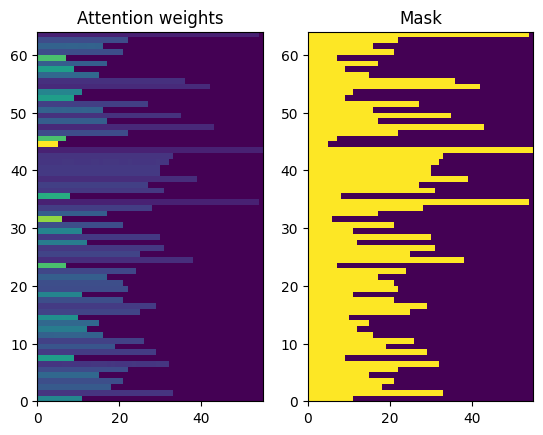

In [31]:
attention_weights = attention_layer.last_attention_weights
mask=(ex_context_tok != 0).numpy()

plt.subplot(1, 2, 1)
plt.pcolormesh(mask*attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(mask)
plt.title('Mask');


Because of the small-random initialization the attention weights are initially all close to `1/(sequence_length)`. The model will learn to make these less uniform as training progresses.

### The decoder

The decoder's job is to generate predictions for the next token at each location in the target sequence.

1. It looks up embeddings for each token in the target sequence.
2. It uses an RNN to process the target sequence, and keep track of what it has generated so far.
3. It uses RNN output as the "query" to the attention layer, when attending to the encoder's output.
4. At each location in the output it predicts the next token.

When training, the model predicts the next word at each location. So it's important that the information only flows in one direction through the model. The decoder uses a unidirectional (not bidirectional) RNN to process the target sequence.

When running inference with this model it produces one word at a time, and those are fed back into the model.

<table>
<tr>
  <td>
   <img width=500 src="https://tensorflow.org/images/tutorials/transformer/RNN.png"/>
  </td>
</tr>
<tr>
  <th>A unidirectional RNN</th>
<tr>
</table>

Here is the `Decoder` class' initializer. The initializer creates all the necessary layers.

In [32]:
class Decoder(tf.keras.layers.Layer):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, text_processor, units):
    super(Decoder, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.word_to_id = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]')
    self.id_to_word = tf.keras.layers.StringLookup(
        vocabulary=text_processor.get_vocabulary(),
        mask_token='', oov_token='[UNK]',
        invert=True)
    self.start_token = self.word_to_id('[START]')
    self.end_token = self.word_to_id('[END]')

    self.units = units


    # 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                               units, mask_zero=True)

    # 2. The RNN keeps track of what's been generated so far.
    self.rnn = tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # 3. The RNN output will be the query for the attention layer.
    self.attention = CrossAttention(units)

    # 4. This fully connected layer produces the logits for each
    # output token.
    self.output_layer = tf.keras.layers.Dense(self.vocab_size)

#### Training

Next, the `call` method, takes 3 arguments:

* `inputs` -  a `context, x` pair where:
  * `context` - is the context from the encoder's output.
  * `x` - is the target sequence input.
* `state` - Optional, the previous `state` output from the decoder (the internal state of the decoder's RNN). Pass the state from a previous run to continue generating text where you left off.
* `return_state` - [Default: False] - Set this to `True` to return the RNN state. 

In [33]:
@Decoder.add_method
def call(self,
         context, x,
         state=None,
         return_state=False):  
  shape_checker = ShapeChecker()
  shape_checker(x, 'batch t')
  shape_checker(context, 'batch s units')

  # 1. Lookup the embeddings
  x = self.embedding(x)
  shape_checker(x, 'batch t units')

  # 2. Process the target sequence.
  x, state = self.rnn(x, initial_state=state)
  shape_checker(x, 'batch t units')

  # 3. Use the RNN output as the query for the attention over the context.
  x = self.attention(x, context)
  self.last_attention_weights = self.attention.last_attention_weights
  shape_checker(x, 'batch t units')
  shape_checker(self.last_attention_weights, 'batch t s')

  # Step 4. Generate logit predictions for the next token.
  logits = self.output_layer(x)
  shape_checker(logits, 'batch t target_vocab_size')

  if return_state:
    return logits, state
  else:
    return logits

That will be sufficient for training. Create an instance of the decoder to test out:

In [34]:
decoder = Decoder(target_text_processor, UNITS)

In training you'll use the decoder like this:

Given the context and target tokens, for each target token it predicts the next target token. 

In [35]:
logits = decoder(ex_context, ex_tar_in)

print(f'encoder output shape: (batch, s, units) {ex_context.shape}')
print(f'input target tokens shape: (batch, t) {ex_tar_in.shape}')
print(f'logits shape shape: (batch, target_vocabulary_size) {logits.shape}')

encoder output shape: (batch, s, units) (64, 55, 256)
input target tokens shape: (batch, t) (64, 53)
logits shape shape: (batch, target_vocabulary_size) (64, 53, 5000)


#### Inference

To use it for inference you'll need a couple more methods:

In [36]:
@Decoder.add_method
def get_initial_state(self, context):
  batch_size = tf.shape(context)[0]
  start_tokens = tf.fill([batch_size, 1], self.start_token)
  done = tf.zeros([batch_size, 1], dtype=tf.bool)
  embedded = self.embedding(start_tokens)
  return start_tokens, done, self.rnn.get_initial_state(embedded)[0]

In [37]:
@Decoder.add_method
def tokens_to_text(self, tokens):
  words = self.id_to_word(tokens)
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
  result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
  return result

In [38]:
@Decoder.add_method
def get_next_token(self, context, next_token, done, state, temperature = 0.0):
  logits, state = self(
    context, next_token,
    state = state,
    return_state=True) 
  
  if temperature == 0.0:
    next_token = tf.argmax(logits, axis=-1)
  else:
    logits = logits[:, -1, :]/temperature
    next_token = tf.random.categorical(logits, num_samples=1)

  # If a sequence produces an `end_token`, set it `done`
  done = done | (next_token == self.end_token)
  # Once a sequence is done it only produces 0-padding.
  next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)
  
  return next_token, done, state

With those extra functions, you can write a generation loop:

In [39]:
# Setup the loop variables.
next_token, done, state = decoder.get_initial_state(ex_context)
tokens = []

for n in range(10):
  # Run one step.
  next_token, done, state = decoder.get_next_token(
      ex_context, next_token, done, state, temperature=1.0)
  # Add the token to the output.
  tokens.append(next_token)

# Stack all the tokens together.
tokens = tf.concat(tokens, axis=-1) # (batch, t)

# Convert the tokens back to a a string
result = decoder.tokens_to_text(tokens)
result[:3].numpy()

array([b'seriously judges taste recommendations authorities fed ghana kurdish followers literature',
       b'madagascar pm austerity han counting portugal ground solve distance palm',
       b'lopez while freedoms hear downtown operations cambodia serbian accepted opposition'],
      dtype=object)

Since the model's untrained, it outputs items from the vocabulary almost uniformly at random.

## The model

Now that you have all the model components, combine them to build the model for training:

In [40]:
class Translator(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, units,
               context_text_processor,
               target_text_processor):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(context_text_processor, units)
    decoder = Decoder(target_text_processor, units)

    self.encoder = encoder
    self.decoder = decoder

  def call(self, inputs):
    context, x = inputs
    context = self.encoder(context)
    logits = self.decoder(context, x)

    #TODO(b/250038731): remove this
    try:
      # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
      del logits._keras_mask
    except AttributeError:
      pass

    return logits

During training the model will be used like this:

In [41]:
model = Translator(UNITS, context_text_processor, target_text_processor)

logits = model((ex_context_tok, ex_tar_in))

print(f'Context tokens, shape: (batch, s, units) {ex_context_tok.shape}')
print(f'Target tokens, shape: (batch, t) {ex_tar_in.shape}')
print(f'logits, shape: (batch, t, target_vocabulary_size) {logits.shape}')

Context tokens, shape: (batch, s, units) (64, 55)
Target tokens, shape: (batch, t) (64, 53)
logits, shape: (batch, t, target_vocabulary_size) (64, 53, 5000)


### Train

For training, you'll want to implement your own masked loss and accuracy functions:

In [42]:
def masked_loss(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')
    loss = loss_fn(y_true, y_pred)

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, loss.dtype)
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

In [43]:
def masked_acc(y_true, y_pred):
    # Calculate the loss for each item in the batch.
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

Configure the model for training:

In [44]:
model.compile(optimizer='adam',
              loss=masked_loss, 
              metrics=[masked_acc, masked_loss])

The model is randomly initialized, and should give roughly uniform output probabilities. So it's easy to predict what the initial values of the metrics should be:

In [45]:
vocab_size = 1.0 * target_text_processor.vocabulary_size()

{"expected_loss": tf.math.log(vocab_size).numpy(),
 "expected_acc": 1/vocab_size}

{'expected_loss': 8.517193, 'expected_acc': 0.0002}

That should roughly match the values returned by running a few steps of evaluation:

In [46]:
model.evaluate(val_ds, steps=20, return_dict=True)

20/20 [==============================] - 5s 35ms/step - loss: 8.5274 - masked_acc: 1.4713e-04 - masked_loss: 8.5274


{'loss': 8.52737808227539,
 'masked_acc': 0.00014713083510287106,
 'masked_loss': 8.52737808227539}

In [47]:
history = model.fit(
    train_ds.repeat(), 
    epochs=100,
    steps_per_epoch = 100,
    validation_data=val_ds,
    validation_steps = 20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3)])

Epoch 1/100


2024-01-23 17:56:08.931068: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT8
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_35/output/_22'
2024-01-23 17:56:09.379607: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fe2d0182e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-23 17:56:09.379666: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, 

100/100 [==============================] - 21s 124ms/step - loss: 5.9198 - masked_acc: 0.1341 - masked_loss: 5.9198 - val_loss: 5.4798 - val_masked_acc: 0.1737 - val_masked_loss: 5.4798
Epoch 2/100
100/100 [==============================] - 10s 95ms/step - loss: 5.1102 - masked_acc: 0.2192 - masked_loss: 5.1102 - val_loss: 4.8916 - val_masked_acc: 0.2413 - val_masked_loss: 4.8916
Epoch 3/100
100/100 [==============================] - 8s 78ms/step - loss: 4.7668 - masked_acc: 0.2507 - masked_loss: 4.7668 - val_loss: 4.6684 - val_masked_acc: 0.2624 - val_masked_loss: 4.6684
Epoch 4/100
100/100 [==============================] - 8s 76ms/step - loss: 4.5463 - masked_acc: 0.2744 - masked_loss: 4.5463 - val_loss: 4.4802 - val_masked_acc: 0.2803 - val_masked_loss: 4.4802
Epoch 5/100
100/100 [==============================] - 6s 62ms/step - loss: 4.3470 - masked_acc: 0.2973 - masked_loss: 4.3470 - val_loss: 4.2438 - val_masked_acc: 0.3068 - val_masked_loss: 4.2438
Epoch 6/100
100/100 [========

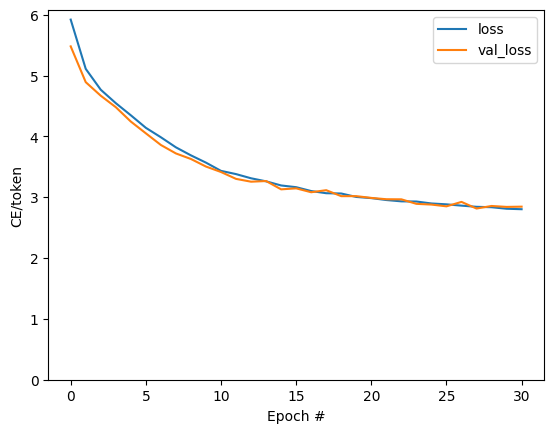

In [48]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

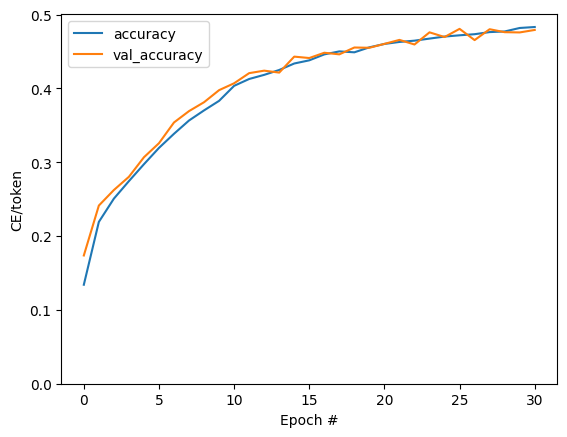

In [49]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

In [50]:
# evaluate the model on the test set 
model.evaluate(test_ds, steps=20, return_dict=True)

20/20 [==============================] - 1s 26ms/step - loss: 2.7699 - masked_acc: 0.4848 - masked_loss: 2.7699


{'loss': 2.7698731422424316,
 'masked_acc': 0.48475804924964905,
 'masked_loss': 2.7698731422424316}

### Translate

Now that the model is trained, implement a function to execute the full `text => text` translation. This code is basically identical to the [inference example](#inference) in the [decoder section](#the_decoder), but this also captures the attention weights.

In [51]:
#@title
@Translator.add_method
def translate(self,
              texts, *,
              max_length=50,
              temperature=0.0):
  # Process the input texts
  context = self.encoder.convert_input(texts)
  batch_size = tf.shape(texts)[0]

  # Setup the loop inputs
  tokens = []
  attention_weights = []
  next_token, done, state = self.decoder.get_initial_state(context)

  for _ in range(max_length):
    # Generate the next token
    next_token, done, state = self.decoder.get_next_token(
        context, next_token, done,  state, temperature)
        
    # Collect the generated tokens
    tokens.append(next_token)
    attention_weights.append(self.decoder.last_attention_weights)
    
    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Stack the lists of tokens and attention weights.
  tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
  self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

  result = self.decoder.tokens_to_text(tokens)
  return result

Here are the two helper methods, used above, to convert tokens to text, and to get the next token:

In [52]:
result = model.translate(['Est tu encore à la maison ?'])
result[0].numpy().decode()

'is you still at home ? '

Use that to generate the attention plot:

In [53]:
#@title
@Translator.add_method
def plot_attention(self, text, **kwargs):
  assert isinstance(text, str)
  output = self.translate([text], **kwargs)
  output = output[0].numpy().decode()

  attention = self.last_attention_weights[0]

  context = tf_lower_and_split_punct(text)
  context = context.numpy().decode().split()

  output = tf_lower_and_split_punct(output)
  output = output.numpy().decode().split()[1:]

  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + output, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')

/tmp/ipykernel_353013/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_353013/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


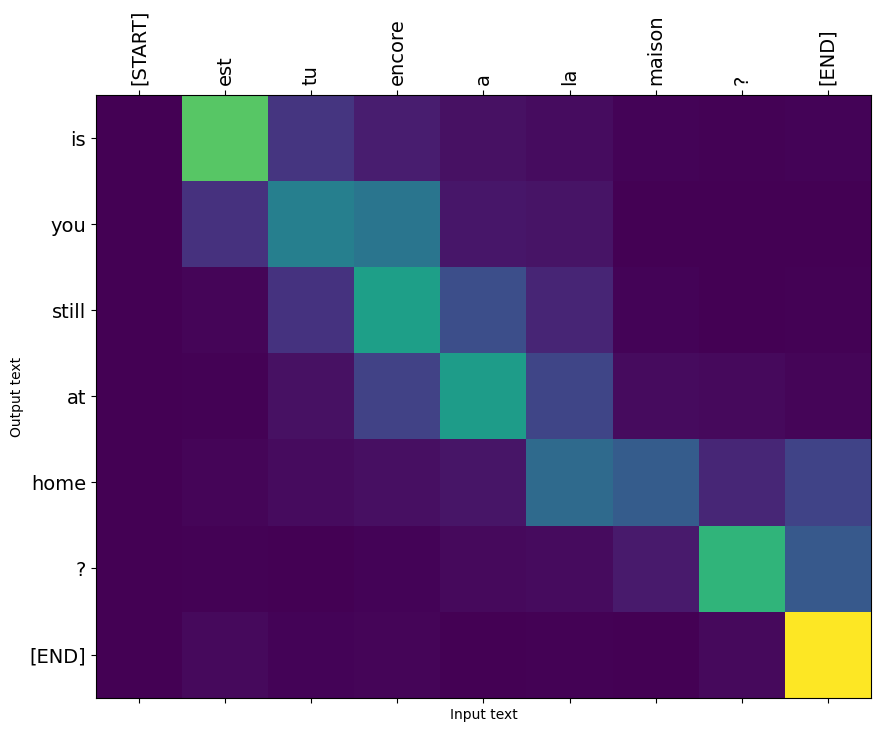

In [54]:
model.plot_attention('Est tu encore à la maison ?')

Translate a few more sentences and plot them:

CPU times: user 219 ms, sys: 36.7 ms, total: 255 ms
Wall time: 229 ms


/tmp/ipykernel_353013/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_353013/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


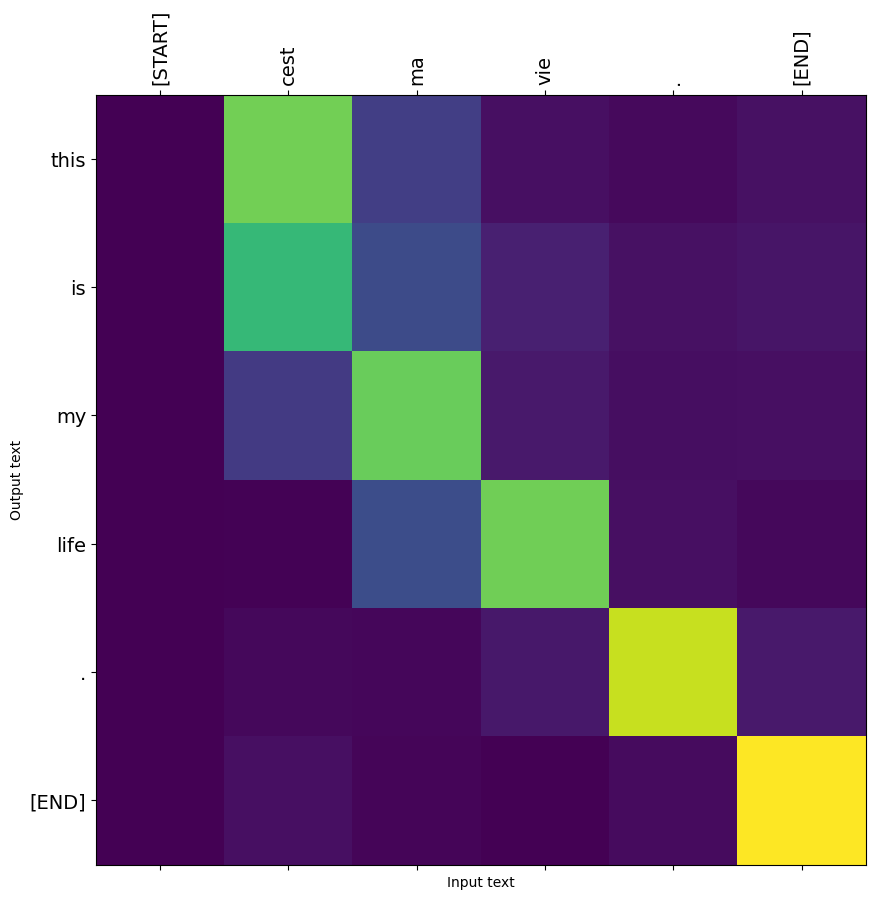

In [55]:
%%time
# This is my life.
model.plot_attention('C\'est ma vie.')

CPU times: user 197 ms, sys: 49.2 ms, total: 246 ms
Wall time: 217 ms


/tmp/ipykernel_353013/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_353013/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


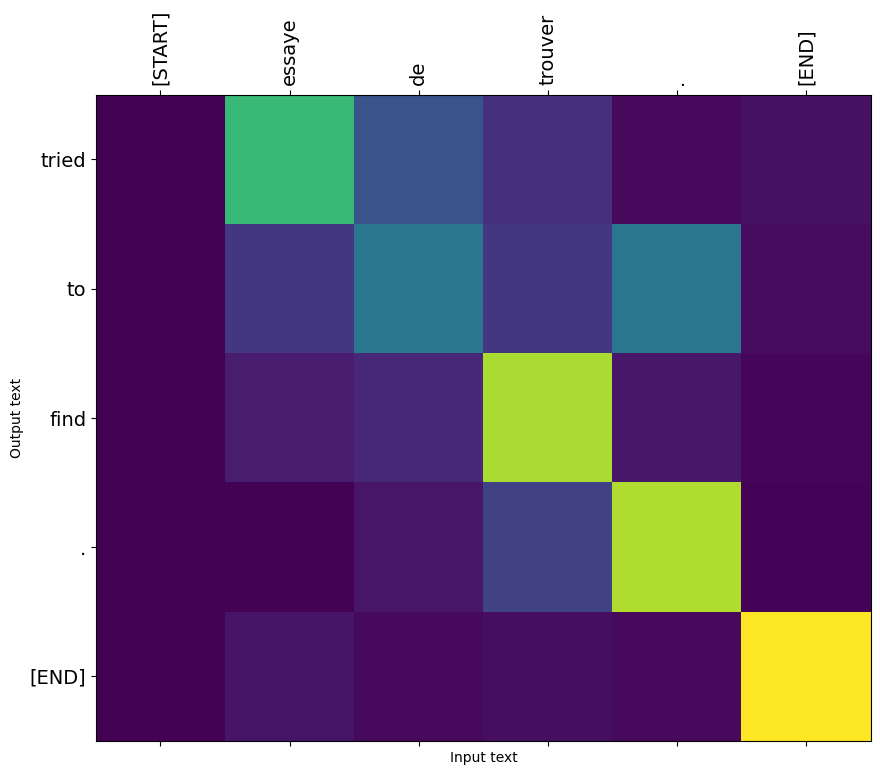

In [56]:
%%time
 # Try to find out.'
model.plot_attention('Essaye de trouver.')

The short sentences often work well, but if the input is too long the model literally loses focus and stops providing reasonable predictions. There are two main reasons for this:

1. The model was trained with teacher-forcing feeding the correct token at each step, regardless of the model's predictions. The model could be made more robust if it were sometimes fed its own predictions.
2. The model only has access to its previous output through the RNN state. If the RNN state looses track of where it was in the context sequence there's no way for the model to recover. [Transformers](transformer.ipynb) improve on this by letting the decoder look at what it has output so far.

The raw data is sorted by length, so try translating the longest sequence:

In [57]:
long_text = context_raw[-1]

import textwrap
print('Expected output:\n', '\n'.join(textwrap.wrap(target_raw[-1])))

Expected output:
 But now she's not wearing bangles.


/tmp/ipykernel_353013/3355722706.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + context, fontdict=fontdict, rotation=90)
/tmp/ipykernel_353013/3355722706.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output, fontdict=fontdict)


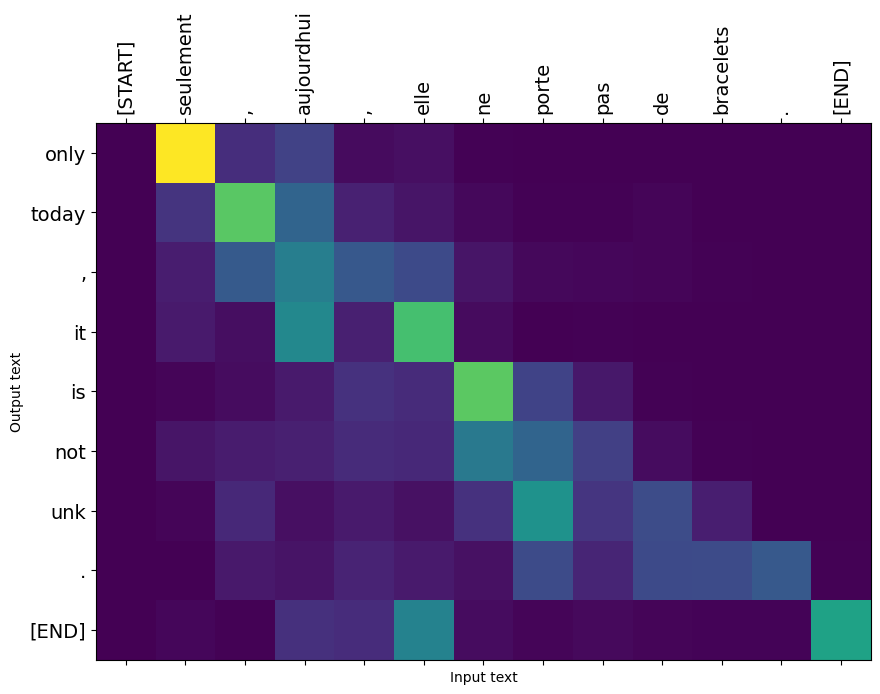

In [58]:
model.plot_attention(long_text)

The `translate` function works on batches, so if you have multiple texts to translate you can pass them all at once, which is much more efficient than translating them one at a time:

In [59]:
def remove_content_after_end(array):
    try:
        index = np.where(array == '[END]')[0][0]  # Find the index of the first occurrence of [END]
        return array[:index]
    except IndexError:
        return array

we split the test_raw into candidates_to_translate and references to translate against. The candidates are translated and the references are kept as is. The BLEU score is then calculated between the candidates and references.

In [214]:
def process_ids(context_ids, targ_in_ids, targ_out_ids=None):
    context_tokens = context_vocab[context_ids.numpy()]
    context = ' '.join(context_tokens)

    target_in_tokens = target_vocab[targ_in_ids.numpy()]
    target_in = ' '.join(target_in_tokens)

    return context, target_in

def process_batch(ex_context_tok, ex_tar_in, ex_tar_out):
    batch_size = tf.shape(ex_context_tok)[0]
    return tf.map_fn(lambda i: process_ids(ex_context_tok[i], ex_tar_in[i]), tf.range(batch_size), dtype=(tf.string, tf.string))

references_to_keep = []
candidates_to_translate = []

for (ex_context_tok, ex_tar_in), ex_tar_out in test_ds:
    batch_contexts, batch_targets = process_batch(ex_context_tok, ex_tar_in, ex_tar_out)
    candidates_to_translate.extend(candidate.decode() for candidate in batch_contexts.numpy())
    references_to_keep.extend(target.decode() for target in batch_targets.numpy())
    
len(references_to_keep), len(candidates_to_translate)

(34206, 34206)

We create a function to batch translate sentences, to fasten up the process.

In [215]:
def remove_special_tokens(text):
    text = text.replace('[START]', '')
    text = text.replace('[END]', '')
    return text

In [216]:
def translate_on_batch(model, candidates_to_translate, batch_size=128):
    candidates = []
    for i in range(0, len(candidates_to_translate), batch_size):
        result = model.translate(candidates_to_translate[i:i+batch_size])
        candidates.extend([decoded_sentence.numpy().decode('utf-8') for decoded_sentence in result])
    return candidates

In [227]:
n_values_to_test = len(references_to_keep)
references = references_to_keep[:n_values_to_test]
candidates = translate_on_batch(model, candidates_to_translate[:n_values_to_test])

we also compute the length of each sentence and the bleu score on each sentence for later use.

In [228]:
data = []
for i in range(n_values_to_test):
    data.append({
            'Context': candidates_to_translate[i],
            'Reference': references[i], 
            'Candidate': candidates[i], 
            'length': len(references[i].split())
        })

As we want to compute the bleu score on length buckets, we split the data based on the reference length.

In [229]:
# split into small dataset based on the sentences length
length_ranges = [(1, 5), (6, 10), (11, 15), (16, 20), (21, 30), (31, 40), (41, 60), (61, float('inf'))]

small_datasets = {}
for min_len, max_len in length_ranges:
    filtered_examples = [example for example in data if example['length'] >= min_len and example['length'] <= max_len]
    small_datasets[f'dataset_{min_len}_{max_len}'] = filtered_examples

# Access the smaller datasets
samples_per_range = []
for key, dataset in small_datasets.items():
    samples_per_range.append(len(dataset))
    print(f"{key}: {len(dataset)} samples")

dataset_1_5: 894 samples
dataset_6_10: 5362 samples
dataset_11_15: 6158 samples
dataset_16_20: 5733 samples
dataset_21_30: 8689 samples
dataset_31_40: 4383 samples
dataset_41_60: 2514 samples
dataset_61_inf: 473 samples


In [230]:
def compute_corpus_bleu(references, candidates):
    if len(references) != len(candidates):
        raise ValueError('The number of references and candidates must be the same :', len(references), len(candidates))
    
    if len(references) == 0: return 0.0
    
    reference_tokens = [[ref] for ref in references]
    return corpus_bleu(reference_tokens, candidates)

In [231]:
bleu_scores = []
for key, dataset in small_datasets.items():
    refs = [example['Reference'] for example in dataset]
    cands = [example['Candidate'] for example in dataset]
    
    corpus_bleu_score = compute_corpus_bleu(refs, cands)
    bleu_scores.append(corpus_bleu_score)
    
    print(f"{key}: {corpus_bleu_score:.4f}")

dataset_1_5: 0.6323


dataset_6_10: 0.5945
dataset_11_15: 0.5718
dataset_16_20: 0.5589
dataset_21_30: 0.5403
dataset_31_40: 0.5258
dataset_41_60: 0.4944
dataset_61_inf: 0.3706


In [232]:
overall_bleu_score = corpus_bleu([[ref] for ref in references], candidates)

In [233]:
overall_bleu_score

0.5415764479170317

In [234]:
model.translate(["nous avons utilise nos connexions et nos reseaux pour obtenir des dons sous forme de vêtements ou d'aliments"])[0].numpy().decode()

'we used our [UNK] and our networks to obtain donations and [UNK] [UNK] '

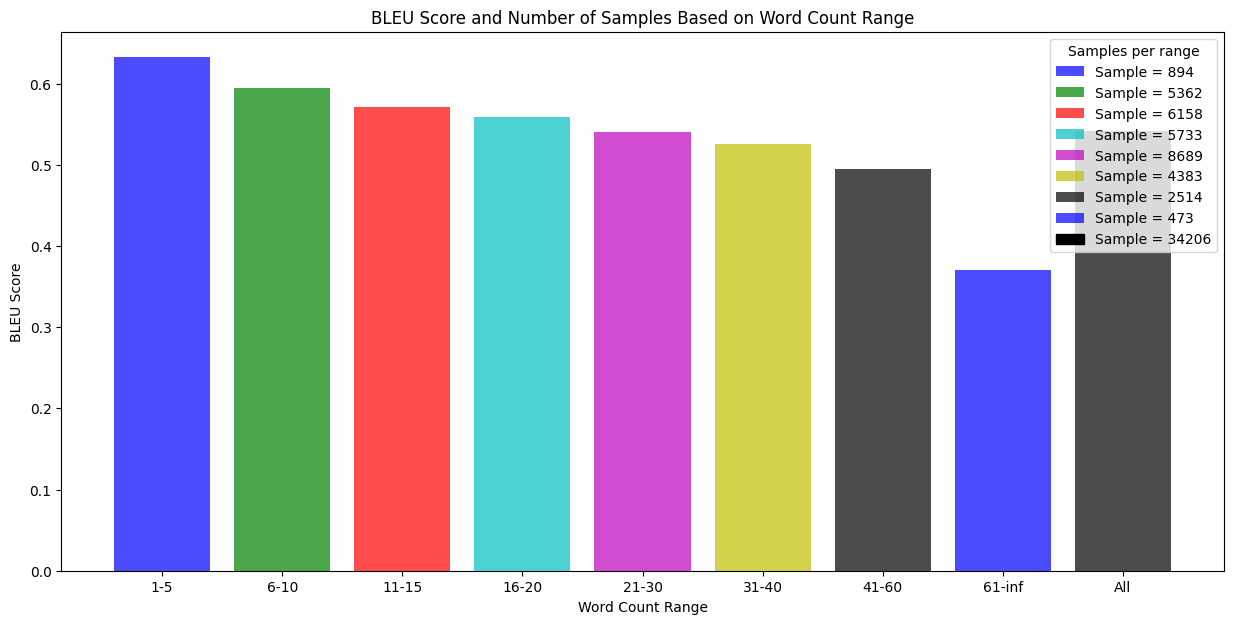

In [237]:
import matplotlib.patches as mpatches

plt.figure(figsize=(15, 7))

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # List of colors for each bar
bar_plot = plt.bar([f'{start}-{end}' for start, end in length_ranges], bleu_scores, color=colors, alpha=0.7, label='BLEU Score')

# Add "All" bar with legend
all_bar = plt.bar("All", overall_bleu_score, color='k', alpha=0.7)

# Create a dummy handle for the "All" bar
all_patch = mpatches.Patch(color='k', label=f'Sample = {len(candidates)}')
legend_labels = [f'Sample = {value}' for value in samples_per_range]

# Include the dummy handle in the legend
plt.legend(handles=[*bar_plot, all_patch], labels=legend_labels + [f'Sample = {len(candidates)}'], loc='upper right', title='Samples per range')

plt.xlabel('Word Count Range')
plt.ylabel('BLEU Score')

plt.title('BLEU Score and Number of Samples Based on Word Count Range')

plt.show()

In [242]:
translation = model.translate(['il fait très beau aujourd\'hui'])
translation[0].numpy().decode()

'it is very beautiful today '

So overall this text generation function mostly gets the job done, but so you've only used it here in python with eager execution. Let's try to export it next:

### Export

If you want to export this model you'll need to wrap the `translate` method in a `tf.function`. That implementation will get the job done:


In [ ]:
class Export(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
  def translate(self, inputs):
    return self.model.translate(inputs)

In [ ]:
export = Export(model)

Run the `tf.function` once to compile it:

In [ ]:
inputs = [
    'Est tu encore à la maison ?',
    'C\'est ma vie.',
    'Essaye de trouver.',
    'Je suis un homme.',
    'Je suis une femme.',
    'Je suis un garçon.'
]

In [ ]:
%%time
_ = export.translate(tf.constant(inputs))

In [ ]:
%%time
result = export.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print(result[3].numpy().decode())
print(result[4].numpy().decode())
print(result[5].numpy().decode())
print()

Now that the function has been traced it can be exported using `saved_model.save`:

In [ ]:
%%time
tf.saved_model.save(export, '../models/nmt_with_attention_tensorflow',
                    signatures={'serving_default': export.translate})

In [ ]:
%%time
reloaded = tf.saved_model.load('../models/nmt_with_attention_tensorflow')
_ = reloaded.translate(tf.constant(inputs)) #warmup

In [ ]:
%%time
result = reloaded.translate(tf.constant(inputs))

print(result[0].numpy().decode())
print(result[1].numpy().decode())
print(result[2].numpy().decode())
print()

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs.
* Try the [transformer tutorial](transformer.ipynb) which implements a similar translation task but uses transformer layers instead of RNNs. This version also uses a `text.BertTokenizer` to implement word-piece tokenization.
* Visit the [`tensorflow_addons.seq2seq` tutorial](https://www.tensorflow.org/addons/tutorials/networks_seq2seq_nmt), which demonstrates a higher-level functionality for implementing this sort of sequence-to-sequence model, such as `seq2seq.BeamSearchDecoder`.